# Collecting and Visualizing Fitbit Data for a Single Date
To start viewing your own data and saving it as a CSV, you really only need to adjust the following variables in this notebook:

  * USER_ID, CLIENT_SECRET (your own Fitbit credentials)
  * date

## 1. Import the necessary Python libraries and modules: 

In [21]:
#!/usr/bin/python      
%matplotlib inline

import fitbit
import matplotlib.pyplot as plt
import gather_keys_oauth2 as Oauth2
import numpy as np
import datetime
import pandas as pd
import csv
import re
import seaborn as sns
from scipy.stats import linregress 
from IPython.display import display

## 2. Access the Fitbit API
Replace 'your USER_ID' and 'your CLIENT_SECRET' ([follow this tutorial to obtain these](http://blog.mr-but-dr.xyz/en/programming/fitbit-python-heartrate-howto/)) to access your Fitbit data:

In [7]:
"""provide your credentials for OAuth2.0"""
USER_ID = 'your USER_ID' # should look something like this: '123A4B'
CLIENT_SECRET = 'your CLIENT_SECRET' # should look something like this: 'c321fvdc59b4cc62156n9luv20k39072'

"""obtain access and refresh tokens"""
server = Oauth2.OAuth2Server(USER_ID, CLIENT_SECRET)
server.browser_authorize()
 
ACCESS_TOKEN = server.oauth.token['access_token']
REFRESH_TOKEN = server.oauth.token['refresh_token']
 
"""complete authorization"""
auth2_client = fitbit.Fitbit(USER_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

[08/Jul/2016:11:02:28] ENGINE Listening for SIGHUP.
INFO:cherrypy.error:[08/Jul/2016:11:02:28] ENGINE Listening for SIGHUP.
[08/Jul/2016:11:02:28] ENGINE Listening for SIGTERM.
INFO:cherrypy.error:[08/Jul/2016:11:02:28] ENGINE Listening for SIGTERM.
[08/Jul/2016:11:02:28] ENGINE Listening for SIGUSR1.
INFO:cherrypy.error:[08/Jul/2016:11:02:28] ENGINE Listening for SIGUSR1.
[08/Jul/2016:11:02:28] ENGINE Bus STARTING
INFO:cherrypy.error:[08/Jul/2016:11:02:28] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[08/Jul/2016:11:02:28] ENGINE Started monitor thread '_TimeoutMonitor'.
INFO:cherrypy.error:[08/Jul/2016:11:02:28] ENGINE Started monitor thread '_TimeoutMonitor'.
[08/Jul/2016:11:02:28] ENGINE Started monitor thread 'Autoreloader'.
INFO:cherrypy.error:[08/Jul/2016:11:02:28] ENGINE Started monitor thread 'Autoreloader'.
[08/Jul/2016:11:02:28] ENGINE Serving on http://127.0.0.1:8080
INFO:cherrypy.error:[08/Jul/2016:11:02:28] ENGINE Serving on ht

127.0.0.1 - - [08/Jul/2016:11:02:30] "GET /?code=71b183924efdf94ba8456369520fb5b26493d893&state=aTE5MrXIvdkCT2iUyKP6Gjb67Cgqeo HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"


## 3. Pick a Date

In [115]:
date=str(datetime.date(2016, 3, 9))

## 4. Collect Time-Series Data


In [141]:
"""Timeseries data of Calories and Activity Level"""

fitbit_cals = auth2_client.intraday_time_series('activities/log/calories', base_date=date, detail_level='1min')
Calstats = fitbit_cals['activities-log-calories-intraday']['dataset']
Cals=pd.DataFrame(Calstats)

print "----CALORIE STATS----"
print 'First 5 Rows of Calories Data:'
print Cals.head(n=5)
print 'Total Calorie Samples (fixed):', len(Cals.index)

Calsmax = Cals['value'].max()
Calsmin = Cals['value'].min()
Calsmean = Cals['value'].mean()
CalsSumm = Cals['value'].sum()

print "Total Calories burned:", CalsSumm 
print "Min Calories burned in a minute:", Calsmin 
print "Max Calories burned in a minute:", Calsmax 

#Save Calorie Timeseries to CSV
del Cals['mets'] # delets 'mets' column 
del Cals['level'] # delete 'level' column

Cals=Cals.transpose()
Cals.columns = Cals.iloc[0]
Cals=Cals.reindex(Cals.index.drop('time'))
Cals=Cals.rename(index={'value': str(date)})

full_index=Cals.columns.values
Cals.to_csv('Cals-timeseries.csv')

----CALORIE STATS----
First 5 Rows of Calories Data:
   level  mets      time   value
0      0    10  00:00:00  0.9986
1      0    10  00:01:00  0.9986
2      0    10  00:02:00  0.9986
3      0    10  00:03:00  0.9986
4      0    10  00:04:00  0.9986
Total Calorie Samples (fixed): 1440
Total Calories burned: 1913.51731384
Min Calories burned in a minute: 0.998600006104
Max Calories burned in a minute: 6.59076023102


In [143]:
"""Timeseries data of Heartrate"""

fitbit_stats = auth2_client.intraday_time_series('activities/heart', base_date=date, detail_level='1min')
stats = fitbit_stats['activities-heart-intraday']['dataset']
HR=pd.DataFrame(stats)

print "----HEART RATE STATS----"
print 'First 5 Samples of Heart Rate Data:'
print HR.head(n=5)
print 'Total HR Samples (variable):', len(HR.index)

HRmax = HR['value'].max()
HRmin = HR['value'].min()
HRmean = HR['value'].mean()

print "Avg HR:", HRmean
print "Max HR:", HRmax
print "Min HR:", HRmin

#Save HR Timeseries to CSV
HR=HR.transpose()
HR.columns = HR.iloc[0]
HR=HR.reindex(HR.index.drop('time'))
HR2=HR.transpose()
full_HR=HR2.reindex(full_index) # reindex with the full_index of times from Calorie series 
HR=full_HR.transpose()
HR=HR.rename(index={'value': str(date)})
HR.to_csv('HR-timeseries.csv')

----HEART RATE STATS----
First 5 Samples of Heart Rate Data:
       time  value
0  00:00:00     58
1  00:01:00     63
2  00:02:00     64
3  00:03:00     64
4  00:04:00     65
Total HR Samples (variable): 1420
Avg HR: 67.0042253521
Max HR: 118
Min HR: 51


In [146]:
"""Timeseries data of Steps"""

fitbit_steps = auth2_client.intraday_time_series('activities/steps', base_date=date, detail_level='1min')
Stepsstats = fitbit_steps['activities-steps-intraday']['dataset']
Steps=pd.DataFrame(Stepsstats)

print "----STEPS STATS----"
print 'First 5 Rows of Steps Data:'
print Steps.head(n=5)
print 'Total Steps Samples (fixed):', len(Steps.index)

Stepsmax = Steps['value'].max()
Stepsmin = Steps['value'].min()
Stepsmean = Steps['value'].mean()
StepsSumm = Steps['value'].sum()

print "Total Steps walked:", StepsSumm 
print "Min Steps walked in a minute:", Stepsmin 
print "Max Steps walked in a minute:", Stepsmax 
print "Average Steps walked in a minute:", Stepsmean

#Save Steps Timeseries to CSV
Steps=Steps.transpose()
Steps.columns = Steps.iloc[0]
Steps=Steps.reindex(Steps.index.drop('time'))
Steps=Steps.rename(index={'value': str(date)})
Steps.to_csv('Steps-timeseries.csv')

----STEPS STATS----
First 5 Rows of Steps Data:
       time  value
0  00:00:00      0
1  00:01:00      0
2  00:02:00      0
3  00:03:00      0
4  00:04:00      0
Total Steps Samples (fixed): 1440
Total Steps walked: 4960
Min Steps walked in a minute: 0
Max Steps walked in a minute: 106
Average Steps walked in a minute: 3.44444444444


In [89]:
"""Timeseries data of Sleep"""
fitbit_sleep = auth2_client.sleep(date)
try: # try the following:
    sleepstats = fitbit_sleep['sleep'][0]['minuteData']
except IndexError: # create empty/filler data if no timeseries data collected:
    filler=pd.DataFrame(np.empty(1400, dtype=object))
    full_filler=filler.reindex(full_index) # reindex with the full_index of times from the Calorieseries function 
    filler=full_filler.transpose()
    filler=filler.rename(index={0: str(date)}) # rename the index (row name) with the corresponding date
    Sleep=filler
else: # check for multiple sleep records
    if len(fitbit_sleep['sleep']) >= 2: # if multiple sleep records exist for one day, combine all records:
        for record in range(1,len(fitbit_sleep['sleep'])-1): # loop through sleep records
            temp=fitbit_sleep['sleep'][record]['minuteData'] # create temporary sleep record
            sleepstats = sleepstats + [x for x in temp if x not in sleepstats] # append temporary record to full sleepstats
    else: # if there are not multiple records, continue with initial sleepstats variable:
        pass   
    Sleep=pd.DataFrame(sleepstats)
    Sleep['dateTime']=Sleep['dateTime'].astype(str)
    sleeptimes=Sleep['dateTime']
    i=0
    for val in Sleep['dateTime']: 
        val2=re.sub('30$', '00', val)
        Sleep.set_value(i,'dateTime',val2)
        i=i+1

values=Sleep['value']
SleepValues = values.astype(float)

print "----SLEEP STATS----"
print 'First 5 Rows of Sleep Data:'
print Sleep.head(n=5)
print 'Total Sleep Minutes Sampled (variable):', len(Sleep.index)

counts = Sleep['value'].value_counts().to_dict()
counts['Asleep (1)'] = counts.pop('1')
counts['Awake (2)'] = counts.pop('2')
counts['Very Awake (3)'] = counts.pop('3')

print counts
    
Sleep=Sleep.transpose()
Sleep.columns = Sleep.iloc[0] # use 'time' stamp to rename columns with 00:00, 00:01 ... 23:58, 23:59
Sleep=Sleep.reindex(Sleep.index.drop('dateTime')) # drop redundant information (time now reflected as column name)
Sleep2=Sleep.transpose()
full_Sleep=Sleep2.reindex(full_index) # reindex with the full_index of times from the Calorieseries function 
Sleep=full_Sleep.transpose()
Sleep=Sleep.rename(index={'value': str(date)}) 
Sleep.to_csv('Sleep-timeseries3.csv')

----SLEEP STATS----
First 5 Rows of Sleep Data:
   dateTime value
0  22:55:00     2
1  22:56:00     2
2  22:57:00     2
3  22:58:00     1
4  22:59:00     1
Total Sleep Minutes Sampled (variable): 503
{'Very Awake (3)': 8, 'Awake (2)': 50, 'Asleep (1)': 445}


## 5. Plot Time-Series Data

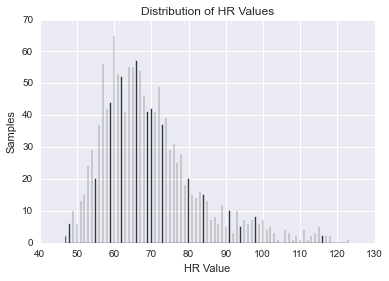

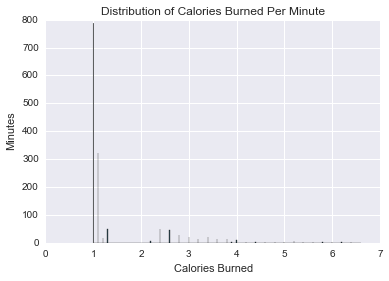

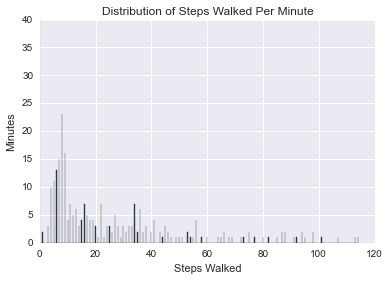

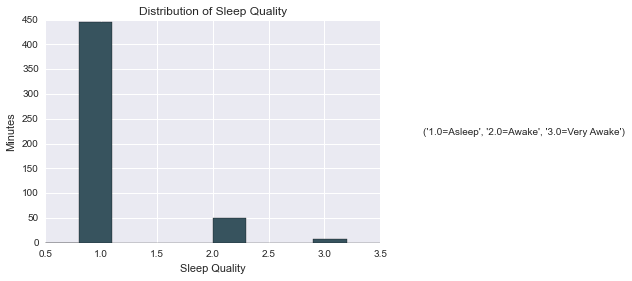

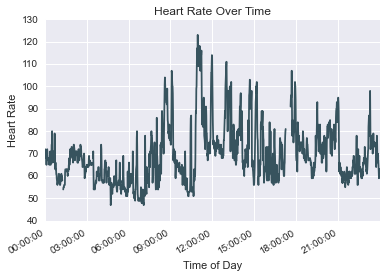

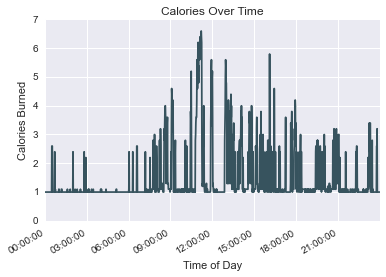

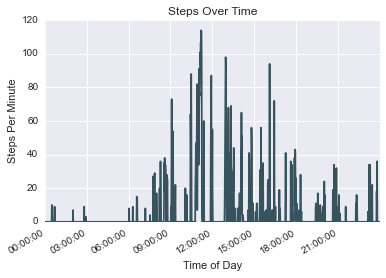

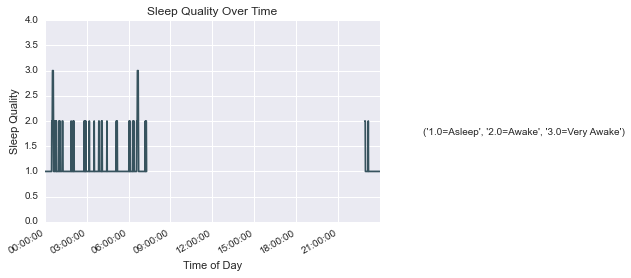

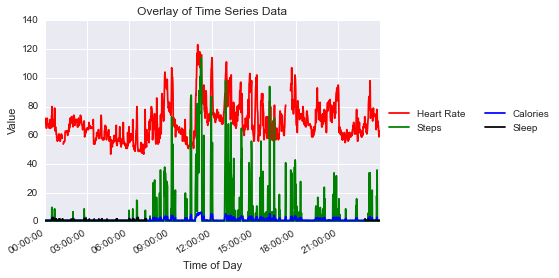

In [116]:
"""Histograms"""

# HR Histogram
plt.figure(1)
plt.hist(HR.iloc[0], bins=len(stats), range=(HRmin,HRmax))
#sns.distplot(HR);
plt.title('Distribution of HR Values')
plt.ylabel('Samples')
plt.xlabel('HR Value')

# Calories Histogram
plt.figure(2)
plt.hist(Cals.iloc[0], bins=len(Calstats), range=(Calsmin,Calsmax))
#sns.distplot(Cals);
plt.title('Distribution of Calories Burned Per Minute')
plt.ylabel('Minutes')
plt.xlabel('Calories Burned')

# Steps Histogram
plt.figure(3)
plt.hist(Steps.iloc[0], bins=len(Stepsstats), range=(Stepsmin,Stepsmax))
#sns.distplot(Steps);
axes = plt.gca()
axes.set_ylim([0,40])
plt.title('Distribution of Steps Walked Per Minute')
plt.ylabel('Minutes')
plt.xlabel('Steps Walked')

# Sleep Histogram
fig = plt.figure(4)
plt.hist(SleepValues, range=(0.5,3.5))
#sns.distplot(Sleep);
plt.title('Distribution of Sleep Quality')
plt.ylabel('Minutes')
plt.xlabel('Sleep Quality')
quality = '1.0=Asleep', '2.0=Awake', '3.0=Very Awake'
fig.text(1,.5,quality)

"""Line Plots"""

time=pd.to_datetime(full_index)
time1 = [t.replace(year=2016, month=6, day=13) for t in time]

# HR Over Time
plt.figure(5)
plt.plot(time1, HR.iloc[0])
plt.gcf().autofmt_xdate()
plt.title('Heart Rate Over Time')
plt.ylabel('Heart Rate')
plt.xlabel('Time of Day')

# Calories Over Time
plt.figure(6)
plt.plot(time1, Cals.iloc[0])
plt.gcf().autofmt_xdate()
plt.title('Calories Over Time')
plt.ylabel('Calories Burned ')
plt.xlabel('Time of Day')

# Steps Over Time
plt.figure(7)
plt.plot(time1, Steps.iloc[0])
plt.gcf().autofmt_xdate()
plt.title('Steps Over Time')
plt.ylabel('Steps Per Minute ')
plt.xlabel('Time of Day')

# Sleep Quality Over Time
fig=plt.figure(8)
plt.plot(time1, list(Sleep.iloc[0]))
plt.gcf().autofmt_xdate()
plt.gca().set_ylim([0,4])
plt.title('Sleep Quality Over Time')
plt.ylabel('Sleep Quality ')
plt.xlabel('Time of Day')
quality = '1.0=Asleep', '2.0=Awake', '3.0=Very Awake'
fig.text(1,.5,quality)

fig=plt.figure(9)
plt.plot(time1, HR.iloc[0], 'r', label="Heart Rate")
plt.plot(time1, Steps.iloc[0], 'g', label="Steps")
plt.plot(time1, Cals.iloc[0], 'b', label="Calories")
plt.plot(time1, list(Sleep.iloc[0]), 'k',label="Sleep")
plt.gcf().autofmt_xdate()
#plt.yscale('log') #Log Scale
plt.legend( loc='center left', numpoints = 1, fancybox=True, shadow=True, bbox_to_anchor=(1, 0.5),ncol=2)
plt.title('Overlay of Time Series Data')
plt.ylabel('Value')
plt.xlabel('Time of Day')

plt.show()

## 6. Collect Daily Summary Data

In [137]:
"""SLEEP SUMMARY"""

SleepStats = fitbit_sleep['sleep']
del SleepStats[0]['minuteData']

SleepSumm=pd.DataFrame(SleepStats)
SleepSumm=SleepSumm.rename(index={0: str(date)})
SleepSumm.to_csv('Sleep-Summary.csv')


In [138]:
""" ACTIVITIES SUMMARY """

active_list = auth2_client.activities(date)
activities_summary=active_list['summary']

'''Distances Summary'''

distances=activities_summary['distances']
DistSumm=pd.DataFrame(distances)
DistSumm=DistSumm.transpose()
DistSumm.columns = DistSumm.iloc[0]
DistSumm=DistSumm.reindex(DistSumm.index.drop('activity'))
DistSumm=DistSumm.rename(index={'distance': str(date)})
DistSumm.to_csv('Distances-Summary.csv')

'''HR Zones Summary'''

HRzones=activities_summary['heartRateZones'] 
HRSumm=pd.DataFrame(HRzones) 
HRSumm.rows = HRSumm.iloc[0]
HRSumm=HRSumm.rename(index={0:"Out of Range", 1:"Fat Burn", 2:"Cardio", 3:"Peak"})
del HRSumm['name'] #delete duplicated info now that indexes are named
HRflat=HRSumm.values.flatten() #Flatten dataframe into single row
HRSumm2=pd.DataFrame(HRflat)
HRSumm2=HRSumm2.transpose()
HRSumm2=HRSumm2.rename(columns={0:"OutRange.caloriesOut", 1:"OR.max", 2:"OR.min", 3:"OR.minutes", 4:"FatBurn.caloriesOut", 5:"FB.max", 6:"FB.min", 7:"FB.minutes", 8:"Cardio.caloriesOut", 9:"C.max", 10:"C.min", 11:"C.minutes", 12:"Peak.caloriesOut", 13:"P.max", 14:"P.min", 15:"P.minutes"})
HRSumm2=HRSumm2.rename(index={0: str(date)})
HRSumm2.to_csv('HR-Summary.csv')

"""Remaining Activity Data Summary"""

del activities_summary['distances']
del activities_summary['heartRateZones']

ActivitiesSumm=pd.DataFrame(activities_summary.items())
ActivitiesSumm=ActivitiesSumm.transpose()
ActivitiesSumm.columns = ActivitiesSumm.iloc[0]
ActivitiesSumm=ActivitiesSumm.reindex(ActivitiesSumm.index.drop(0))
ActivitiesSumm=ActivitiesSumm.rename(index={1: str(date)})
ActivitiesSumm.to_csv('Activities-Summary.csv')

## 7. Explore Files/Data Frames! 

In [148]:
from IPython.display import display
"""preview the first 5 rows of each data frame"""

print "Activity Summary"
display(ActivitiesSumm)

print "Distances Summary"
display(DistSumm)

print "Heart Rate Zones Summary"
display(HRSumm2)

print "Sleep Summary"
display(SleepSumm)

print "Sleep Time-Series"
display(Sleep)

print "Calories Time-Series"
display(Cals)

print "Steps Time-Series"
display(Steps)

print "Heart Rate Time-Series"
display(HR)

Activity Summary


,marginalCalories,elevation,sedentaryMinutes,lightlyActiveMinutes,caloriesOut,caloriesBMR,fairlyActiveMinutes,veryActiveMinutes,activityCalories,steps,floors,activeScore,restingHeartRate
2016-03-09,282,200,734,201,1913,1437,0,0,621,4960,20,-1,61


Distances Summary


activity,total,tracker,loggedActivities,veryActive,moderatelyActive,lightlyActive,sedentaryActive
2016-03-09,2.04,2.04,0,0,0,2.04,0


Heart Rate Zones Summary


,OutRange.caloriesOut,OR.max,OR.min,OR.minutes,FatBurn.caloriesOut,FB.max,FB.min,FB.minutes,Cardio.caloriesOut,C.max,C.min,C.minutes,Peak.caloriesOut,P.max,P.min,P.minutes
2016-03-09,1845.71238,99,30,1409,47.13392,139,99,11,0,169,139,0,0,220,169,0


Sleep Summary


,awakeCount,awakeDuration,awakeningsCount,dateOfSleep,duration,efficiency,isMainSleep,logId,minutesAfterWakeup,minutesAsleep,minutesAwake,minutesToFallAsleep,restlessCount,restlessDuration,startTime,timeInBed
2016-03-09,2,8,34,2016-02-01,30180000,88,True,10774693527,0,445,58,0,32,50,2016-01-31T22:55:00.000,503


Sleep Time-Series


dateTime,00:00:00,00:01:00,00:02:00,00:03:00,00:04:00,00:05:00,00:06:00,00:07:00,00:08:00,00:09:00,...,23:50:00,23:51:00,23:52:00,23:53:00,23:54:00,23:55:00,23:56:00,23:57:00,23:58:00,23:59:00
2016-02-01,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Calories Time-Series


time,00:00:00,00:01:00,00:02:00,00:03:00,00:04:00,00:05:00,00:06:00,00:07:00,00:08:00,00:09:00,...,23:50:00,23:51:00,23:52:00,23:53:00,23:54:00,23:55:00,23:56:00,23:57:00,23:58:00,23:59:00
2016-03-09,0.9986,0.9986,0.9986,0.9986,0.9986,0.9986,0.9986,0.9986,0.9986,0.9986,...,0.9986,0.9986,0.9986,0.9986,1.09846,1.09846,0.9986,0.9986,1.09846,0.9986


Steps Time-Series


time,00:00:00,00:01:00,00:02:00,00:03:00,00:04:00,00:05:00,00:06:00,00:07:00,00:08:00,00:09:00,...,23:50:00,23:51:00,23:52:00,23:53:00,23:54:00,23:55:00,23:56:00,23:57:00,23:58:00,23:59:00
2016-03-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Heart Rate Time-Series


time,00:00:00,00:01:00,00:02:00,00:03:00,00:04:00,00:05:00,00:06:00,00:07:00,00:08:00,00:09:00,...,23:50:00,23:51:00,23:52:00,23:53:00,23:54:00,23:55:00,23:56:00,23:57:00,23:58:00,23:59:00
2016-03-09,58,63,64,64,65,65,67,67,67,67,...,61,61,59,62,62,61,61,56,57,59
